In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sci
from PyDSTool import *
import scipy.optimize as sco
from scipy import optimize
from scipy.interpolate import interp1d
import mpld3
from tabulate import tabulate

## Parameters and Initial Conditions

In [2]:
# it looks, based on the XPP file from the authors, like they start CRH, ACTH, CORT and GR at 0 each and just run
# the solver until they reach some steady state

y0 = [1,28.7,8.6123,2]
icdict = {'CRH':0, 'ACTH':0, 'CORT':0, 'GR':2.28}

In [3]:
# initialize dictionaries for each of the three groups which include k_stress and k_i (the only parameters 
#     that vary between groups)

pardict_normal = {'k_stress':10.1, 'k_i':1.51, 'V_S3':3.25, 'K_m1':1.74, 'K_P2':8.3, 'V_S4':0.907, 'K_m2':0.112, 'K_P3':0.945, 'V_S5':0.00535, 'K_m3':0.0768, 'K_d1':0.00379, 'K_d2':0.00916, 'K_d3':0.356, 'n1':5.43, 'n2':5.1, 'K_b':0.0202, 'G_tot':3.28, 'V_S2':0.0509, 'K1':0.645, 'K_d5':0.0854}
pardict_depressed = {'k_stress':13.7, 'k_i':1.6, 'V_S3':3.25, 'K_m1':1.74, 'K_P2':8.3, 'V_S4':0.907, 'K_m2':0.112, 'K_P3':0.945, 'V_S5':0.00535, 'K_m3':0.0768, 'K_d1':0.00379, 'K_d2':0.00916, 'K_d3':0.356, 'n1':5.43, 'n2':5.1, 'K_b':0.0202, 'G_tot':3.28, 'V_S2':0.0509, 'K1':0.645, 'K_d5':0.0854}
pardict_PTSD = {'k_stress':17.5, 'k_i':1.17, 'V_S3':3.25, 'K_m1':1.74, 'K_P2':8.3, 'V_S4':0.907, 'K_m2':0.112, 'K_P3':0.945, 'V_S5':0.00535, 'K_m3':0.0768, 'K_d1':0.00379, 'K_d2':0.00916, 'K_d3':0.356, 'n1':5.43, 'n2':5.1, 'K_b':0.0202, 'G_tot':3.28, 'V_S2':0.0509, 'K1':0.645, 'K_d5':0.0854}

In [4]:
# initialize parameter values that stay the same between all three groups
#     These are the optimized values that the authors got from SensSB toolbox

V_S3 = 3.25
K_m1 = 1.74
K_P2 = 8.3
V_S4 = 0.907
K_m2 = 0.112
K_P3 = 0.945
V_S5 = 0.00535
K_m3 = 0.0768
K_d1 = 0.00379
K_d2 = 0.00916
K_d3 = 0.356
n1 = 5.43
n2 = 5.1
K_b = 0.0202
G_tot = 3.28
V_S2 = 0.0509
K1 = 0.645
K_d5 = 0.0854

In [5]:
# or we can initialize the parameters that stay the same as the literature values and optimize all parameters and
#     see what happens

V_S3 = 1.58 # reported as 1.58-5
K_m1 = 2
K_P2 = 0.3 # reported as 0.3-1.8
V_S4 = 1.58 # reported as 1.58-5
K_m2 = 2
K_P3 = 0.3 # reported as 0.3-1.8
V_S5 = 1.58 # reported as 1.58-5
K_m3 = 2
K_d1 = 0.173
K_d2 = 0.035
K_d3 = 0.009
n1 = 5
n2 = 4
K_b = 0.01 # no literature value reported
G_tot = 2 # no literature value reported
V_S2 = 0 # reported as 0-1
K1 = 1
K_d5 = 0.01
p_stress = 10

In [6]:
# define the bounds for the parameters to be optimized, k_stress and k_i
bounds = [(5,20), (0.5,3)]

In [7]:
# here are the bounds used for all of the parameters, assuming we want to optimize more than just k_stress and k_i
bounds = [(5,20), (0.5,3), (3,4), (1,2), (7,11), (0.5,1.5), (0.08,2), (0.5,1.2), (0.001,0.008), (0.03,0.08), (0.002,0.005), (0.001,0.01), (0.1,0.5), (4,6), (4,6), (0.008,0.05), (2,5), (0.01,0.07), (0.2,0.7), (0.04,0.09)]

In [8]:
# wider bounds for fitting other data sets than original
bounds = [(1,30), (0.1,5), (1,10), (.1,10), (1,31), (0.1,10.5), (0.001,10), (0.1,10), (0.001,0.1), (0.001,0.5), (0.001,0.1), (0.001,0.1), (0.01,5), (1,15), (1,15), (0.001,0.5), (.02,45), (0.0001,7), (0.02,7), (0.004,0.9)]

In [9]:
# wider bounds with p_stress included for Nelson data
bounds = [(1,30), (0.1,5), (1,10), (.1,10), (1,31), (0.1,10.5), (0.001,10), (0.1,10), (0.001,0.1), (0.001,0.5), (0.001,0.1), (0.001,0.1), (0.01,5), (1,15), (1,15), (0.001,0.5), (.02,45), (0.0001,7), (0.02,7), (0.004,0.9), (1,100)]


In [10]:
# length of time over which we wish to integrate
timeLength = (-0.01,2.35)

# time interval and step definition, based on XPP model from authors
t_start = -0.01
t_end = 2.35
t_step = 0.01

## Put Raw Data Into Arrays

In [11]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [12]:
# convert time scales to hours for the raw data, because the model is in terms of hours
for i in range(len(yehudaControlCortisol)):
    yehudaControlCortisol[i,0] = yehudaControlCortisol[i,0]/60
    yehudaPTSDCortisol[i,0] = yehudaPTSDCortisol[i,0]/60
    yehudaDepressedCortisol[i,0] = yehudaDepressedCortisol[i,0]/60

In [13]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [14]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [15]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [16]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [17]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [18]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

In [19]:
# data from Dr Erik Nelson
nelsonACTH_data = np.genfromtxt("tsst_acth_nelson.txt")
nelsonCortisol_data = np.genfromtxt("tsst_cort_nelson.txt")

### Smooth Data, If Desired

In [20]:
# this function computes the moving average over the neighboring 5 points
def smoothing(a, n=5) :
    idx = int((n-1)/2)
    ret = np.cumsum(a, dtype=float)
    ret[idx+1:-idx] = ret[n:] - ret[:-n]
    ret[idx] = ret[idx+2]
    return ret[idx:-idx] / n

In [21]:
yehudaControlCortisol_smooth = yehudaControlCortisol
yehudaPTSDCortisol_smooth = yehudaPTSDCortisol
yehudaDepressedCortisol_smooth = yehudaDepressedCortisol

yehudaControlCortisol_smooth[2:-2,1] = smoothing(yehudaControlCortisol[:,1])
yehudaPTSDCortisol_smooth[2:-2,1] = smoothing(yehudaPTSDCortisol[:,1])
yehudaDepressedCortisol_smooth[2:-2,1] = smoothing(yehudaDepressedCortisol[:,1])

In [22]:
# run smoothing if so desired
# REMEMBER: need to re-extract the data from the files into the non-smooth arrays to make them non-smooth.
#     I'm still not sure why it's smoothing the original data when I only save the values from the smoothing function
#     into the smooth arrays
carrollControlCortisol_smooth = carrollControlCortisol
carrollHCDepressedCortisol_smooth = carrollHCDepressedCortisol
carrollLCDepressedCortisol_smooth = carrollLCDepressedCortisol

carrollControlACTH_smooth = carrollControlACTH
carrollHCDepressedACTH_smooth = carrollHCDepressedACTH
carrollLCDepressedACTH_smooth = carrollLCDepressedACTH

carrollControlCortisol_rearr_smooth = carrollControlCortisol_rearr
carrollHCDepressedCortisol_rearr_smooth = carrollHCDepressedCortisol_rearr
carrollLCDepressedCortisol_rearr_smooth = carrollLCDepressedCortisol_rearr

carrollControlACTH_rearr_smooth = carrollControlACTH_rearr
carrollHCDepressedACTH_rearr_smooth = carrollHCDepressedACTH_rearr
carrollLCDepressedACTH_rearr_smooth = carrollLCDepressedACTH_rearr

carrollControlCortisol_smooth[2:-2,1] = smoothing(carrollControlCortisol[:,1])
carrollHCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol[:,1])
carrollLCDepressedCortisol_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol[:,1])

carrollControlACTH_smooth[2:-2,1] = smoothing(carrollControlACTH[:,1])
carrollHCDepressedACTH_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH[:,1])
carrollLCDepressedACTH_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH[:,1])

carrollControlCortisol_rearr_smooth[2:-2,1] = smoothing(carrollControlCortisol_rearr[:,1])
carrollHCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedCortisol_rearr[:,1])
carrollLCDepressedCortisol_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedCortisol_rearr[:,1])

carrollControlACTH_rearr_smooth[2:-2,1] = smoothing(carrollControlACTH_rearr[:,1])
carrollHCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollHCDepressedACTH_rearr[:,1])
carrollLCDepressedACTH_rearr_smooth[2:-2,1] = smoothing(carrollLCDepressedACTH_rearr[:,1])

In [23]:
golierPTSDCortisol_smooth = golierPTSDCortisol
golierNonPTSDTraumaExposedCortisol_smooth = golierNonPTSDTraumaExposedCortisol
golierNonPTSDNonExposedCortisol_smooth = golierNonPTSDNonExposedCortisol
golierPTSDACTH_smooth = golierPTSDACTH
golierNonPTSDTraumaExposedACTH_smooth = golierNonPTSDTraumaExposedACTH
golierNonPTSDNonExposedACTH_smooth = golierNonPTSDNonExposedACTH

golierPTSDCortisol_smooth[2:-2,1] = smoothing(golierPTSDCortisol[:,1])
golierNonPTSDTraumaExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol[:,1])
golierNonPTSDNonExposedCortisol_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol[:,1])

golierPTSDACTH_smooth[2:-2,1] = smoothing(golierPTSDACTH[:,1])
golierNonPTSDTraumaExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH[:,1])
golierNonPTSDNonExposedACTH_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH[:,1])

In [24]:
golierPTSDCortisol_rearr_smooth = golierPTSDCortisol_rearr
golierNonPTSDTraumaExposedCortisol_rearr_smooth = golierNonPTSDTraumaExposedCortisol_rearr
golierNonPTSDNonExposedCortisol_rearr_smooth = golierNonPTSDNonExposedCortisol_rearr
golierPTSDACTH_rearr_smooth = golierPTSDACTH_rearr
golierNonPTSDTraumaExposedACTH_rearr_smooth = golierNonPTSDTraumaExposedACTH_rearr
golierNonPTSDNonExposedACTH_rearr_smooth = golierNonPTSDNonExposedACTH_rearr

golierPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(golierPTSDCortisol_rearr[:,1])
golierNonPTSDTraumaExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedCortisol_rearr[:,1])
golierNonPTSDNonExposedCortisol_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedCortisol_rearr[:,1])

golierPTSDACTH_rearr_smooth[2:-2,1] = smoothing(golierPTSDACTH_rearr[:,1])
golierNonPTSDTraumaExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDTraumaExposedACTH_rearr[:,1])
golierNonPTSDNonExposedACTH_rearr_smooth[2:-2,1] = smoothing(golierNonPTSDNonExposedACTH_rearr[:,1])

In [25]:
bremnerAbusedPTSDCortisol_rearr_smooth = bremnerAbusedPTSDCortisol_rearr
bremnerNonAbusedPTSDCortisol_rearr_smooth = bremnerNonAbusedPTSDCortisol_rearr
bremnerNonAbusedNonPTSDCortisol_rearr_smooth = bremnerNonAbusedNonPTSDCortisol_rearr

bremnerAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol_rearr[:,1])
bremnerNonAbusedNonPTSDCortisol_rearr_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol_rearr[:,1])

In [26]:
bremnerAbusedPTSDCortisol_smooth = bremnerAbusedPTSDCortisol
bremnerNonAbusedPTSDCortisol_smooth = bremnerNonAbusedPTSDCortisol
bremnerNonAbusedNonPTSDCortisol_smooth = bremnerNonAbusedNonPTSDCortisol

bremnerAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerAbusedPTSDCortisol[:,1])
bremnerNonAbusedPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedPTSDCortisol[:,1])
bremnerNonAbusedNonPTSDCortisol_smooth[2:-2,1] = smoothing(bremnerNonAbusedNonPTSDCortisol[:,1])

### Re-run Code to Input Non-Smoothed Data into Array

In [27]:
yehudaControlCortisol = np.genfromtxt("yehuda-control-cortisol.txt")
yehudaPTSDCortisol = np.genfromtxt("yehuda-PTSD-cortisol.txt")
yehudaDepressedCortisol = np.genfromtxt("yehuda-depressed-cortisol.txt")

In [28]:
# convert time scales to hours for the raw data, because the model is in terms of hours
for i in range(len(yehudaControlCortisol)):
    yehudaControlCortisol[i,0] = yehudaControlCortisol[i,0]/60
    yehudaPTSDCortisol[i,0] = yehudaPTSDCortisol[i,0]/60
    yehudaDepressedCortisol[i,0] = yehudaDepressedCortisol[i,0]/60

In [29]:
# extract the data from text files into 145x2 arrays
carrollControlCortisol = np.genfromtxt("controlGroupCortisolCarroll.txt", dtype = float)
carrollHCDepressedCortisol = np.genfromtxt("HCDepressedCortisolCarroll.txt", dtype = float)
carrollLCDepressedCortisol = np.genfromtxt("LCDepressedCortisolCarroll.txt", dtype = float)

carrollControlACTH = np.genfromtxt("controlGroupACTHCarroll.txt", dtype = float)
carrollHCDepressedACTH = np.genfromtxt("HCDepressedACTHCarroll.txt", dtype = float)
carrollLCDepressedACTH = np.genfromtxt("LCDepressedACTHCarroll.txt", dtype = float)

In [30]:
# rearrange Carroll data, so that we can start optimizing at midnight and go until 10AM 34 hours later
carrollControlCortisol_rearr = np.vstack((carrollControlCortisol[60:,:], carrollControlCortisol[0:60,:]))
carrollHCDepressedCortisol_rearr = np.vstack((carrollHCDepressedCortisol[60:,:], carrollHCDepressedCortisol[0:60,:]))
carrollLCDepressedCortisol_rearr = np.vstack((carrollLCDepressedCortisol[60:,:], carrollLCDepressedCortisol[0:60,:]))

carrollControlACTH_rearr = np.vstack((carrollControlACTH[60:,:], carrollControlACTH[0:60,:]))
carrollHCDepressedACTH_rearr = np.vstack((carrollHCDepressedACTH[60:,:], carrollHCDepressedACTH[0:60,:]))
carrollLCDepressedACTH_rearr = np.vstack((carrollLCDepressedACTH[60:,:], carrollLCDepressedACTH[0:60,:]))

In [31]:
golierPTSDCortisol = np.genfromtxt("golier-PTSD-cortisol.txt", dtype = float)
golierNonPTSDTraumaExposedCortisol = np.genfromtxt("golier-non-PTSD-trauma-exposed-cortisol.txt", dtype = float)
golierNonPTSDNonExposedCortisol = np.genfromtxt("golier-non-exposed-control-cortisol.txt", dtype = float)

golierPTSDACTH = np.genfromtxt("golier-PTSD-ACTH.txt", dtype = float)
golierNonPTSDTraumaExposedACTH = np.genfromtxt("golier-non-PTSD-trauma-exposed-ACTH.txt", dtype = float)
golierNonPTSDNonExposedACTH = np.genfromtxt("golier-non-exposed-control-ACTH.txt", dtype = float)

In [32]:
golierPTSDCortisol_rearr = np.vstack((golierPTSDCortisol[7:,:], golierPTSDCortisol[0:7,:]))
golierNonPTSDTraumaExposedCortisol_rearr = np.vstack((golierNonPTSDTraumaExposedCortisol[7:,:], golierNonPTSDTraumaExposedCortisol[0:7,:]))
golierNonPTSDNonExposedCortisol_rearr = np.vstack((golierNonPTSDNonExposedCortisol[7:,:], golierNonPTSDNonExposedCortisol[0:7,:]))

golierPTSDACTH_rearr = np.vstack((golierPTSDACTH[3:,:], golierPTSDACTH[0:3,:]))
golierNonPTSDTraumaExposedACTH_rearr = np.vstack((golierNonPTSDTraumaExposedACTH[3:,:], golierNonPTSDTraumaExposedACTH[0:3,:]))
golierNonPTSDNonExposedACTH_rearr = np.vstack((golierNonPTSDNonExposedACTH[3:,:], golierNonPTSDNonExposedACTH[0:3,:]))

In [33]:
bremnerAbusedPTSDCortisol = np.genfromtxt("bremner-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedPTSDCortisol = np.genfromtxt("bremner-non-abused-PTSD-cortisol.txt", dtype = float)
bremnerNonAbusedNonPTSDCortisol = np.genfromtxt("bremner-non-abused-non-PTSD-cortisol.txt", dtype = float)

In [34]:
bremnerAbusedPTSDCortisol_rearr = np.vstack((bremnerAbusedPTSDCortisol[68:,:],bremnerAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedPTSDCortisol_rearr = np.vstack((bremnerNonAbusedPTSDCortisol[68:,:],bremnerNonAbusedPTSDCortisol[0:68,:]))
bremnerNonAbusedNonPTSDCortisol_rearr = np.vstack((bremnerNonAbusedNonPTSDCortisol[68:,:],bremnerNonAbusedNonPTSDCortisol[0:68,:]))

### Plot Data Sets

In [35]:
# make time scale in hours for graphing
j = 0
k = 0
l = 0

timeCarroll = np.zeros(len(carrollControlCortisol[:,0]))
for i in carrollControlCortisol[:,0]:
    timeCarroll[l] = i/60
    l += 1

In [36]:
for i in range(len(carrollControlCortisol_rearr_smooth)):
    carrollControlACTH[i,0] = timeCarroll[i]
    carrollControlACTH_rearr[i,0] = timeCarroll[i]
    carrollControlACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlACTH_smooth[i,0] = timeCarroll[i]
    
    carrollControlCortisol[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr[i,0] = timeCarroll[i]
    carrollControlCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollControlCortisol_smooth[i,0] = timeCarroll[i]
    
    carrollHCDepressedACTH[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedACTH_smooth[i,0] = timeCarroll[i]
    
    carrollLCDepressedACTH[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedACTH_smooth[i,0] = timeCarroll[i]
    
    carrollHCDepressedCortisol[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollHCDepressedCortisol_smooth[i,0] = timeCarroll[i]
    
    carrollLCDepressedCortisol[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_rearr_smooth[i,0] = timeCarroll[i]
    carrollLCDepressedCortisol_smooth[i,0] = timeCarroll[i]

In [37]:
for i in range(len(golierPTSDCortisol[:,0])):
    golierPTSDCortisol_rearr[i,0] = golierPTSDCortisol[i,0]
    golierPTSDCortisol_rearr_smooth[i,0] = golierPTSDCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDTraumaExposedCortisol_rearr_smooth[i,0] = golierNonPTSDTraumaExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    golierNonPTSDNonExposedCortisol_rearr_smooth[i,0] = golierNonPTSDNonExposedCortisol[i,0]
    
for i in range(len(golierPTSDACTH[:,0])):
    golierPTSDACTH_rearr[i,0] = golierPTSDACTH[i,0]
    golierPTSDACTH_rearr_smooth[i,0] = golierPTSDACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDTraumaExposedACTH_rearr_smooth[i,0] = golierNonPTSDTraumaExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr[i,0] = golierNonPTSDNonExposedACTH[i,0]
    golierNonPTSDNonExposedACTH_rearr_smooth[i,0] = golierNonPTSDNonExposedACTH[i,0]

In [38]:
for i in range(len(bremnerAbusedPTSDCortisol[:,0])):
    bremnerAbusedPTSDCortisol_rearr[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]
    bremnerNonAbusedNonPTSDCortisol_rearr_smooth[i,0] = bremnerNonAbusedNonPTSDCortisol[i,0]

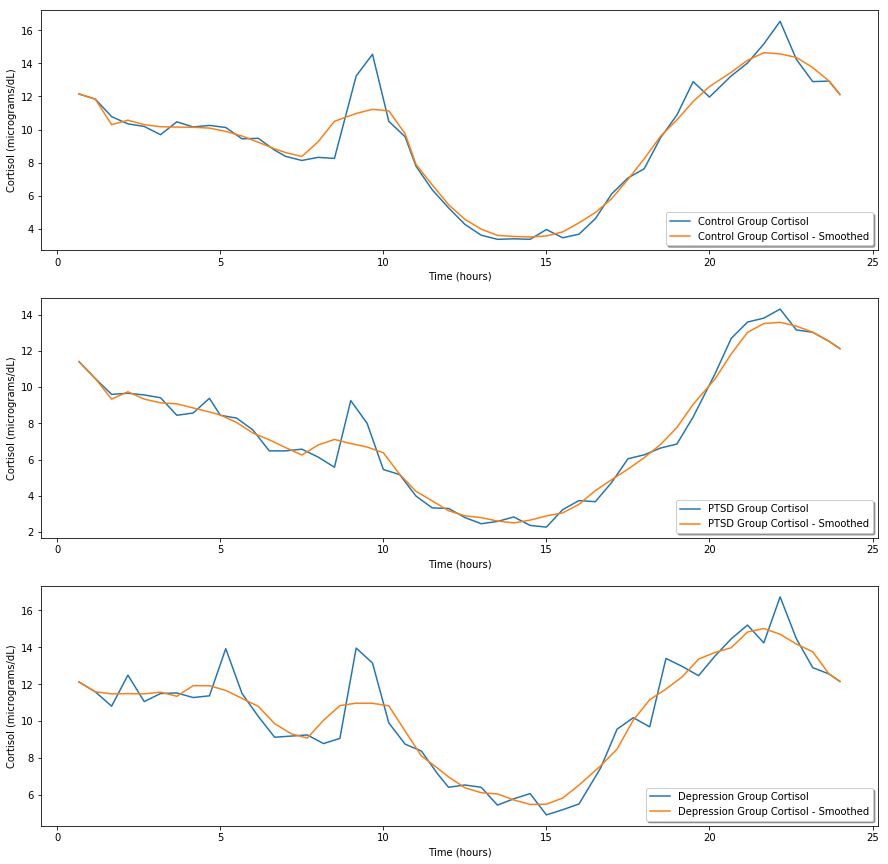

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Control Group Cortisol")
ax1.plot(yehudaControlCortisol_smooth[:,0], yehudaControlCortisol_smooth[:,1], label = "Control Group Cortisol - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(yehudaPTSDCortisol[:,0], yehudaPTSDCortisol[:,1], label = "PTSD Group Cortisol")
ax2.plot(yehudaPTSDCortisol_smooth[:,0], yehudaPTSDCortisol_smooth[:,1], label = "PTSD Group Cortisol - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(yehudaDepressedCortisol[:,0], yehudaDepressedCortisol[:,1], label = "Depression Group Cortisol")
ax3.plot(yehudaDepressedCortisol_smooth[:,0], yehudaDepressedCortisol_smooth[:,1], label = "Depression Group Cortisol - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)


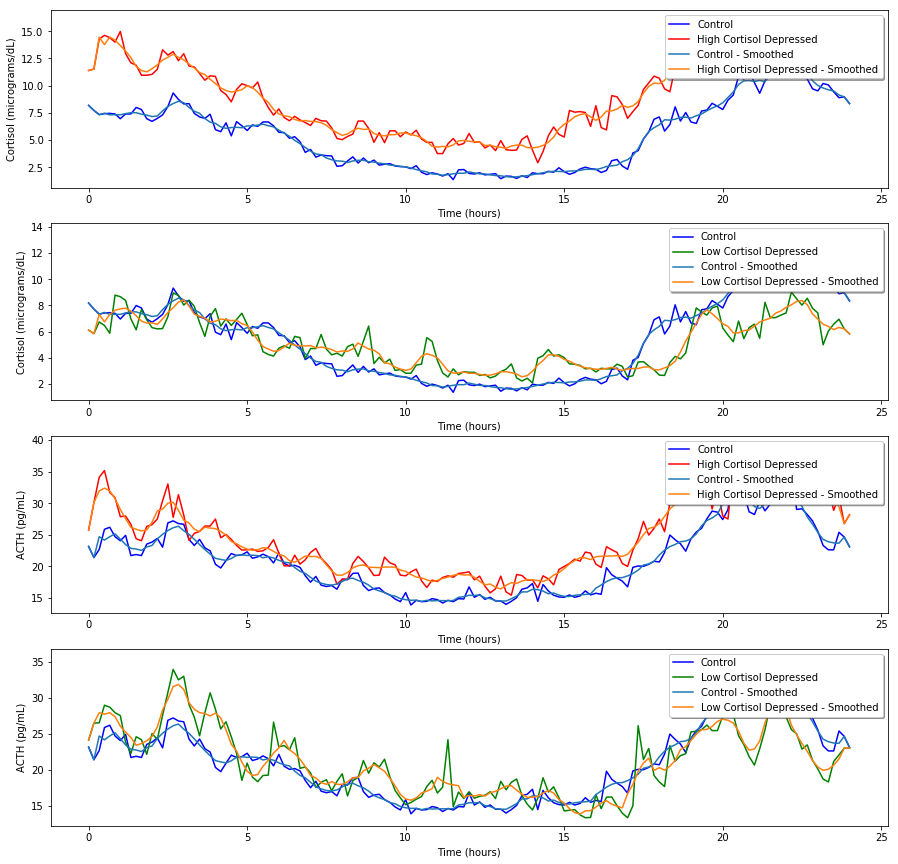

In [40]:
#mpld3.enable_notebook()
%matplotlib inline

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows = 4, figsize = (15,15))

ax1.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax1.plot(carrollHCDepressedCortisol_rearr[:,0], carrollHCDepressedCortisol_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax1.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax1.plot(carrollHCDepressedCortisol_rearr_smooth[:,0], carrollHCDepressedCortisol_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax1.legend(loc="upper right", shadow = True, fancybox = True)

ax2.plot(carrollControlCortisol_rearr[:,0], carrollControlCortisol_rearr[:,1], 'b', label = "Control")
ax2.plot(carrollLCDepressedCortisol_rearr[:,0], carrollLCDepressedCortisol_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax2.plot(carrollControlCortisol_rearr_smooth[:,0], carrollControlCortisol_rearr_smooth[:,1], label = "Control - Smoothed")
ax2.plot(carrollLCDepressedCortisol_rearr_smooth[:,0], carrollLCDepressedCortisol_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (micrograms/dL)")
ax2.legend(loc="upper right", shadow = True, fancybox = True)

ax3.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax3.plot(carrollHCDepressedACTH_rearr[:,0], carrollHCDepressedACTH_rearr[:,1], 'r', label = "High Cortisol Depressed")
ax3.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax3.plot(carrollHCDepressedACTH_rearr_smooth[:,0], carrollHCDepressedACTH_rearr_smooth[:,1], label = "High Cortisol Depressed - Smoothed")
ax3.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax3.legend(loc="upper right", shadow = True, fancybox = True)

ax4.plot(carrollControlACTH_rearr[:,0], carrollControlACTH_rearr[:,1], 'b', label = "Control")
ax4.plot(carrollLCDepressedACTH_rearr[:,0], carrollLCDepressedACTH_rearr[:,1], 'g', label = "Low Cortisol Depressed")
ax4.plot(carrollControlACTH_rearr_smooth[:,0], carrollControlACTH_rearr_smooth[:,1], label = "Control - Smoothed")
ax4.plot(carrollLCDepressedACTH_rearr_smooth[:,0], carrollLCDepressedACTH_rearr_smooth[:,1], label = "Low Cortisol Depressed - Smoothed")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="upper right", shadow = True, fancybox = True)

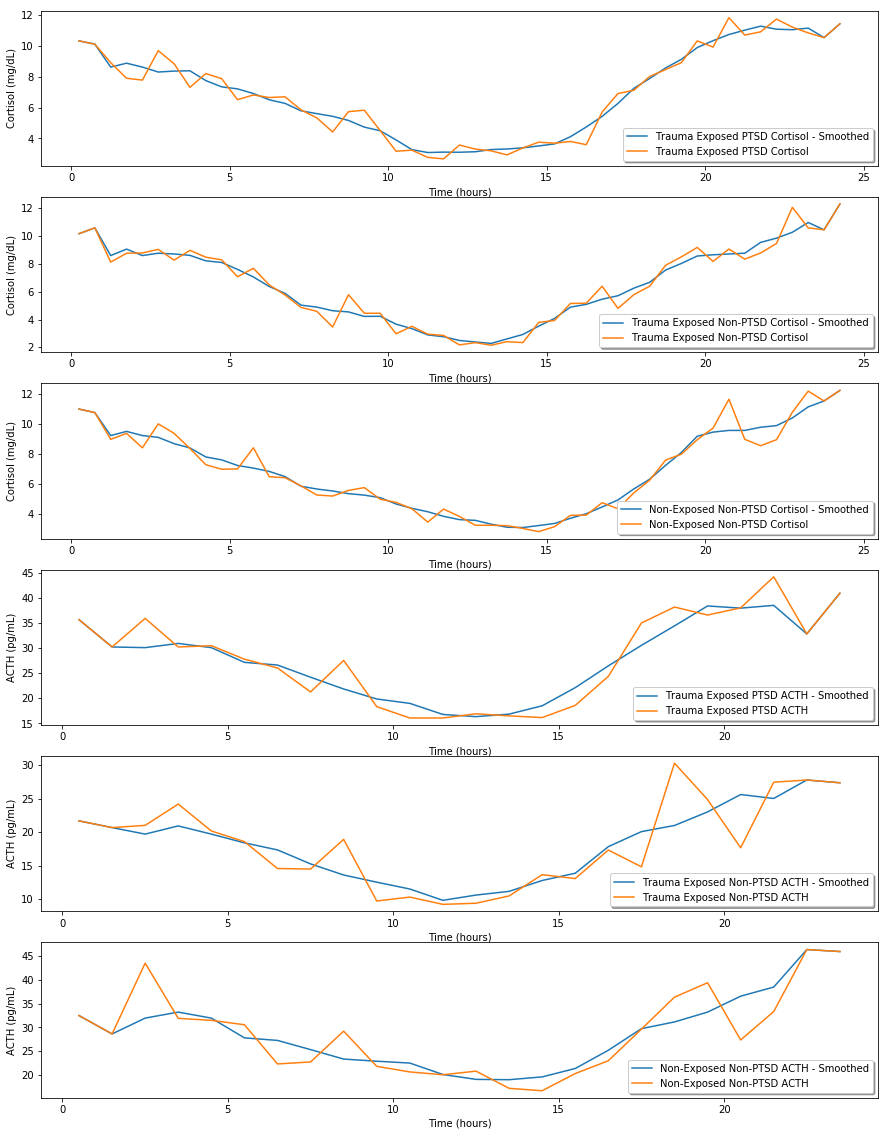

In [41]:
%matplotlib inline

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows = 6, figsize = (15,20))

ax1.plot(golierPTSDCortisol_rearr_smooth[:,0], golierPTSDCortisol_rearr_smooth[:,1], label = "Trauma Exposed PTSD Cortisol - Smoothed")
ax1.plot(golierPTSDCortisol_rearr[:,0], golierPTSDCortisol_rearr[:,1], label = "Trauma Exposed PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,0], golierNonPTSDTraumaExposedCortisol_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD Cortisol - Smoothed")
ax2.plot(golierNonPTSDTraumaExposedCortisol_rearr[:,0], golierNonPTSDTraumaExposedCortisol_rearr[:,1], label = "Trauma Exposed Non-PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(golierNonPTSDNonExposedCortisol_rearr_smooth[:,0], golierNonPTSDNonExposedCortisol_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD Cortisol - Smoothed")
ax3.plot(golierNonPTSDNonExposedCortisol_rearr[:,0], golierNonPTSDNonExposedCortisol_rearr[:,1], label = "Non-Exposed Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (mg/dL)")
ax3.legend(loc="lower right", shadow = True, fancybox = True)

ax4.plot(golierPTSDACTH_rearr_smooth[:,0], golierPTSDACTH_rearr_smooth[:,1], label = "Trauma Exposed PTSD ACTH - Smoothed")
ax4.plot(golierPTSDACTH_rearr[:,0], golierPTSDACTH_rearr[:,1], label = "Trauma Exposed PTSD ACTH")
ax4.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax4.legend(loc="lower right", shadow = True, fancybox = True)

ax5.plot(golierNonPTSDTraumaExposedACTH_rearr_smooth[:,0], golierNonPTSDTraumaExposedACTH_rearr_smooth[:,1], label = "Trauma Exposed Non-PTSD ACTH - Smoothed")
ax5.plot(golierNonPTSDTraumaExposedACTH_rearr[:,0], golierNonPTSDTraumaExposedACTH_rearr[:,1], label = "Trauma Exposed Non-PTSD ACTH")
ax5.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax5.legend(loc="lower right", shadow = True, fancybox = True)

ax6.plot(golierNonPTSDNonExposedACTH_rearr_smooth[:,0], golierNonPTSDNonExposedACTH_rearr_smooth[:,1], label = "Non-Exposed Non-PTSD ACTH - Smoothed")
ax6.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Non-Exposed Non-PTSD ACTH")
ax6.set(xlabel="Time (hours)", ylabel="ACTH (pg/mL)")
ax6.legend(loc="lower right", shadow = True, fancybox = True)


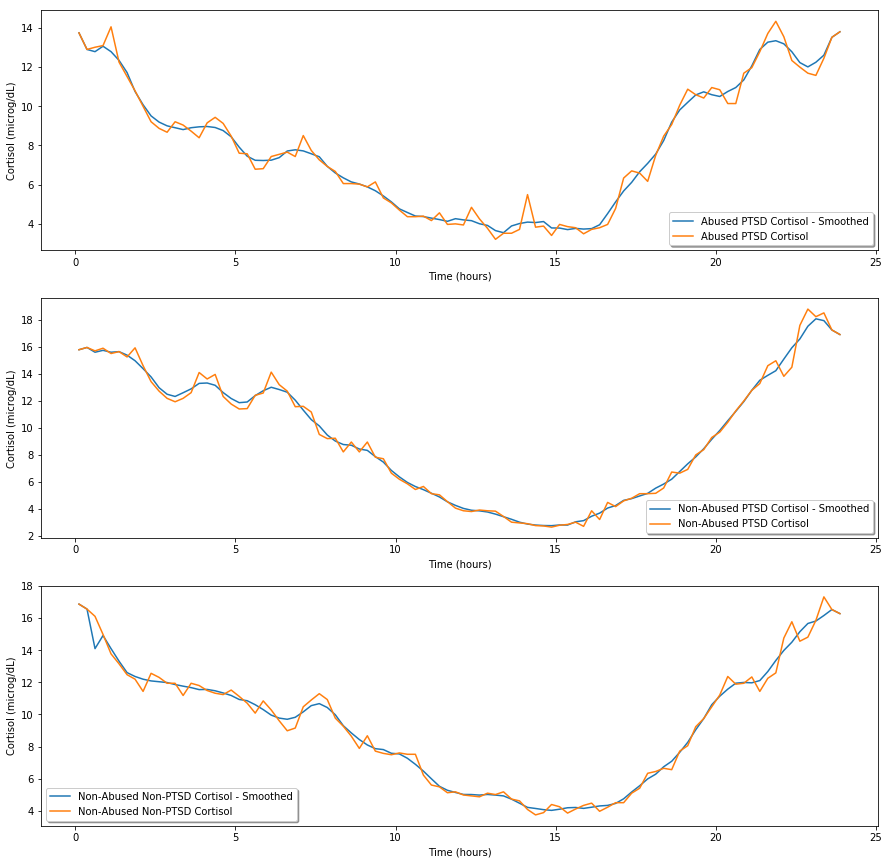

In [42]:
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))

ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Abused PTSD Cortisol - Smoothed")
ax1.plot(bremnerAbusedPTSDCortisol_rearr[:,0], bremnerAbusedPTSDCortisol_rearr[:,1], label = "Abused PTSD Cortisol")
ax1.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax1.legend(loc="lower right", shadow = True, fancybox = True)

ax2.plot(bremnerNonAbusedPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused PTSD Cortisol - Smoothed")
ax2.plot(bremnerNonAbusedPTSDCortisol_rearr[:,0], bremnerNonAbusedPTSDCortisol_rearr[:,1], label = "Non-Abused PTSD Cortisol")
ax2.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax2.legend(loc="lower right", shadow = True, fancybox = True)

ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,0], bremnerNonAbusedNonPTSDCortisol_rearr_smooth[:,1], label = "Non-Abused Non-PTSD Cortisol - Smoothed")
ax3.plot(bremnerNonAbusedNonPTSDCortisol_rearr[:,0], bremnerNonAbusedNonPTSDCortisol_rearr[:,1], label = "Non-Abused Non-PTSD Cortisol")
ax3.set(xlabel="Time (hours)", ylabel="Cortisol (microg/dL)")
ax3.legend(loc="lower left", shadow = True, fancybox = True)


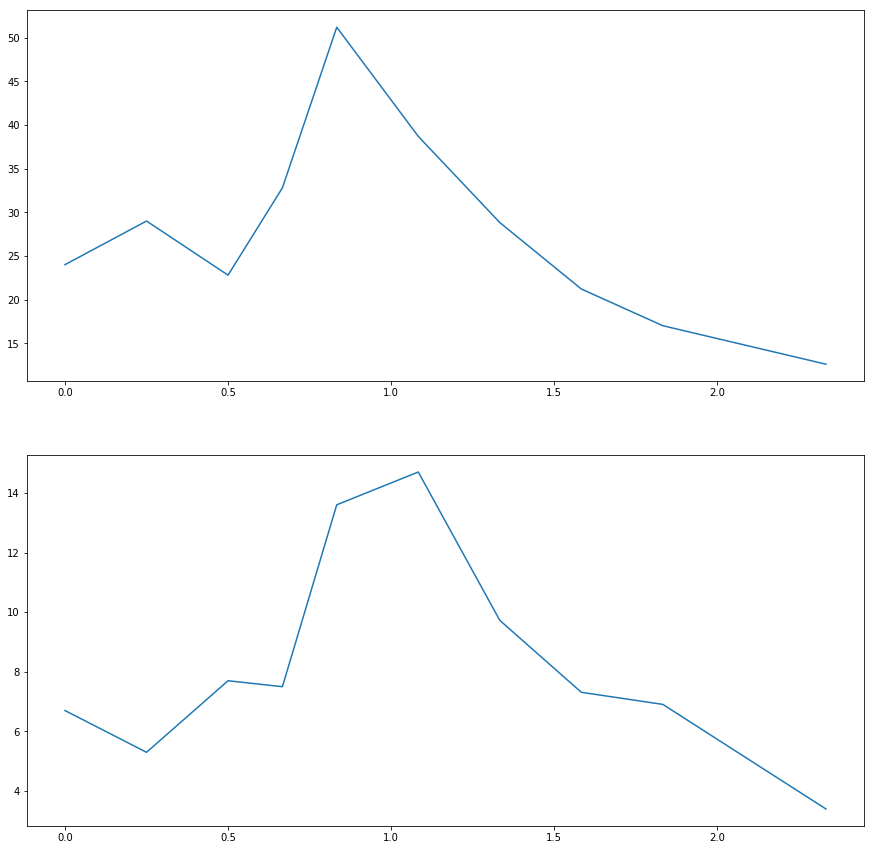

In [43]:
# arrange and graph the Nelson data
nelsonACTH_mean = np.zeros(11)
nelsonCortisol_mean = np.zeros(11)
nelsonACTH = np.zeros((11,60))
nelsonCortisol = np.zeros((11,60))


for i in range(len(nelsonACTH_data[1,:])-1):
    nelsonACTH_mean[i] = np.mean(nelsonACTH_data[:,i+1])
    nelsonCortisol_mean[i] = np.mean(nelsonCortisol_data[:,i+1])

t_nelson = np.array([0, 15, 30, 40, 50, 65, 80, 95, 110, 125, 140])
t_nelson = t_nelson/60

for i in range(len(t_nelson)):
    nelsonACTH[i,0] = t_nelson[i]
    nelsonACTH[i,1] = nelsonACTH_mean[i]
    
    nelsonCortisol[i,0] = t_nelson[i]
    nelsonCortisol[i,1] = nelsonCortisol_mean[i]
    
for i in range(len(nelsonACTH_data)):
    for j in range(len(t_nelson)):
        nelsonACTH[j,i+2] = nelsonACTH_data[i,j+1]
        nelsonCortisol[j,i+2] = nelsonCortisol_data[i,j+1]
    
    

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,3])
ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,3])

## Model Function--Includes ODE Solver

In [192]:
def model(params, ics, t):
    def ode_system(t, y):
        dy = np.zeros(4)

        [k_stress, k_i, V_S3, K_m1, K_P2, V_S4, K_m2, K_P3, V_S5, K_m3, K_d1, K_d2, K_d3, n1, n2, K_b, G_tot, V_S2, K1, K_d5, p_stress] = params
        dy[0] = stress_input(t)*k_stress*(k_i**n2/(k_i**n2 + y[3]**n2)) - V_S3*(y[0]/(K_m1 + y[0])) - K_d1*y[0]
        dy[1] = K_P2*y[0]*(k_i**n2/(k_i**n2 + y[3]**n2)) - V_S4*(y[1]/(K_m2 + y[1])) - K_d2*y[1]
        dy[2] = K_P3*y[1] - V_S5*(y[2]/(K_m3 + y[2])) - K_d3*y[2]
        dy[3] = K_b*y[2]*(G_tot - y[3]) + V_S2*(y[3]**n1/(K1**n1 + y[3]**n1)) - K_d5*y[3]

        return dy
    
    def stress_input(t):
        #if (0.5 <= t <= 0.51):
        if (t >= 0.5):
            return p_stress
        else:
            return 1
    
    # solve the system with scipy.integrate.ode to see if it's any faster
    solver = sci.ode(ode_system)
    solver.set_integrator('vode', method='bdf', atol=3e-12, rtol=1e-12, nsteps = 100000)
    solver.set_initial_value(ics, t_start)
    
    ts = []
    ys = []
    
    while solver.successful() and solver.t < t_end:
        solver.integrate(solver.t + t_step)
        ts.append(solver.t)
        ys.append(solver.y)

    # reshape the output frome ode to an array with the times on the first column
    ts = np.reshape(ts, (len(ts),1))
    ys = np.vstack(ys)
    timeSeries = np.hstack((ts, ys))
    return timeSeries

## Cost Function Definition

In [253]:
def cost_fun(params):
    # call the solve function
    simData = model(params, y0, timeLength)
    
    # this is where Rick makes sure we only have unique values for t, so no time step is repeated
    # I'll include it commented out here, and see if it changes anything later
    #idx = np.unique(simData[:,0], return_index = True)
    #idx = idx[1]
    #simData = simData[idx,:]
    
    # here, rick performs a cubic interpolation between time steps
    # I could either do this, or just compute the SSE between the raw data and computed data points without doing
    # the interpolation (as long as every raw data point is hit by the time steps the model computes)
    spline_ACTH = interp1d(simData[:,0], simData[:,2], kind = 'linear')
    spline_CORT = interp1d(simData[:,0], simData[:,3], kind = 'linear')
    
    try:
        # compute the actual cost value for the current parameter set by finding SSE between raw data and splines
        # this is where we change the data set we are trying to match, so that it computes the cost based on whatever
        #     data set we put in as the x values into the spline and the y values to subtract
        acthSSE = np.sum((spline_ACTH(nelsonACTH[:,0]) - nelsonACTH[:,59])**2)
        cortSSE = np.sum((spline_CORT(nelsonCortisol[:,0]) - nelsonCortisol[:,59])**2)
        
        # if i run it with acth data, also, can make cost the average of cortisol and ACTH SSEs
        cost = (acthSSE+cortSSE)/2
        # for now though, cost is just the SSE of cortisol data and simulation
        #cost = cortSSE
        
        return cost
    except ValueError:
        print("ODE solver did not make through all data points.")

## Run the Optimization

In [251]:
# number of times to run the optimization
n = 1

# define an array to hold the population of parameter vectors
opt_pars = np.zeros((n, len(bounds)+1))

# initialize arrays to save simulation cortisol and ACTH data from each optimization
sims_cort = np.zeros((237, n))
sims_acth = np.zeros((237, n))
sims_crh = np.zeros((237, n))
sims_gr = np.zeros((237, n))

In [254]:
%%time

# loop n times, running the optimization each time
for i in range(0,n):
    
    print(f"Optimization Run #{i+1}")
    
    # call the differential evolution optimization function on the cost function
    res = sco.differential_evolution(cost_fun, bounds, maxiter = 999, disp = True, popsize = 1)
    
    # alternatively, we can run the SHGO algorithm with the sampling_method = "sobol" flag to do global
    #     optimization with reporting all local minima, as well
    #res = sco.shgo(cost_fun, bounds, callback=callback_fun(*shgo_iter_steps), options = {"f_min": 0.1, "maxiter": None, "minimize_every_iter": True, "local_iter": False, "disp": True}, iters = 3)
    #res = sco.basinhopping(cost_fun, x0, niter = 1000)
    #res = sco.dual_annealing(cost_fun, bounds)
    
    # plug the optimized parameters into the solver
    optimizedSimData = model(res.x, y0, timeLength)
    # save CRH, cortisol and ACTH data into sims arrays
    sims_gr[:,i] = optimizedSimData[:,4]
    sims_cort[:,i] = optimizedSimData[:,3]
    sims_acth[:,i] = optimizedSimData[:,2]
    sims_crh[:,i] = optimizedSimData[:,1]
    
    # save the cost function values and optimized parameters for each iteration into the array opt_pars
    opt_pars[i,0] = res.fun
    opt_pars[i,1:] = res.x

Optimization Run #1
differential_evolution step 1: f(x)= 194.852
differential_evolution step 2: f(x)= 194.852
differential_evolution step 3: f(x)= 181.789
differential_evolution step 4: f(x)= 181.789
differential_evolution step 5: f(x)= 181.789
differential_evolution step 6: f(x)= 173.256
differential_evolution step 7: f(x)= 173.256
differential_evolution step 8: f(x)= 173.256
differential_evolution step 9: f(x)= 160.596
differential_evolution step 10: f(x)= 160.596
differential_evolution step 11: f(x)= 146.44
differential_evolution step 12: f(x)= 137.96
differential_evolution step 13: f(x)= 133.576
differential_evolution step 14: f(x)= 133.576
differential_evolution step 15: f(x)= 133.576
differential_evolution step 16: f(x)= 128.07
differential_evolution step 17: f(x)= 128.07
differential_evolution step 18: f(x)= 126.967
differential_evolution step 19: f(x)= 126.967
differential_evolution step 20: f(x)= 125.16
differential_evolution step 21: f(x)= 125.16
differential_evolution step 2

differential_evolution step 178: f(x)= 72.3762
differential_evolution step 179: f(x)= 72.3762
differential_evolution step 180: f(x)= 72.3762
differential_evolution step 181: f(x)= 72.3762
differential_evolution step 182: f(x)= 72.3762
differential_evolution step 183: f(x)= 72.3762
differential_evolution step 184: f(x)= 72.3762
differential_evolution step 185: f(x)= 72.3762
differential_evolution step 186: f(x)= 70.3592
differential_evolution step 187: f(x)= 70.3592
differential_evolution step 188: f(x)= 70.3592
differential_evolution step 189: f(x)= 70.3592
differential_evolution step 190: f(x)= 70.3592
differential_evolution step 191: f(x)= 70.3592
differential_evolution step 192: f(x)= 70.3592
differential_evolution step 193: f(x)= 70.3592
differential_evolution step 194: f(x)= 70.3592
differential_evolution step 195: f(x)= 70.3592
differential_evolution step 196: f(x)= 70.3592
differential_evolution step 197: f(x)= 70.3592
differential_evolution step 198: f(x)= 70.3592
differential_

differential_evolution step 353: f(x)= 57.2558
differential_evolution step 354: f(x)= 57.2558
differential_evolution step 355: f(x)= 57.2558
differential_evolution step 356: f(x)= 57.2558
differential_evolution step 357: f(x)= 57.2558
differential_evolution step 358: f(x)= 57.2558
differential_evolution step 359: f(x)= 57.2558
differential_evolution step 360: f(x)= 57.2558
differential_evolution step 361: f(x)= 57.2558
differential_evolution step 362: f(x)= 57.2558
differential_evolution step 363: f(x)= 57.2558
differential_evolution step 364: f(x)= 57.2558
differential_evolution step 365: f(x)= 57.2558
differential_evolution step 366: f(x)= 57.2558
differential_evolution step 367: f(x)= 57.2558
differential_evolution step 368: f(x)= 57.2558
differential_evolution step 369: f(x)= 56.6723
differential_evolution step 370: f(x)= 56.6723
differential_evolution step 371: f(x)= 56.6723
differential_evolution step 372: f(x)= 56.6723
differential_evolution step 373: f(x)= 56.6723
differential_

differential_evolution step 528: f(x)= 54.2919
differential_evolution step 529: f(x)= 54.2919
differential_evolution step 530: f(x)= 54.2919
differential_evolution step 531: f(x)= 54.2669
differential_evolution step 532: f(x)= 54.2669
differential_evolution step 533: f(x)= 54.2669
differential_evolution step 534: f(x)= 54.2395
differential_evolution step 535: f(x)= 54.2395
differential_evolution step 536: f(x)= 54.2395
differential_evolution step 537: f(x)= 54.2395
differential_evolution step 538: f(x)= 54.2395
differential_evolution step 539: f(x)= 54.2395
differential_evolution step 540: f(x)= 54.2395
differential_evolution step 541: f(x)= 54.2395
differential_evolution step 542: f(x)= 54.2395
differential_evolution step 543: f(x)= 54.2395
differential_evolution step 544: f(x)= 54.2395
differential_evolution step 545: f(x)= 54.1402
differential_evolution step 546: f(x)= 54.1402
differential_evolution step 547: f(x)= 54.1402
differential_evolution step 548: f(x)= 54.1402
differential_

## Save Output to File

In [132]:
np.savetxt('sriramModel-nelson-opt-pars-patient1-1-iteration-with-p-stress.txt', opt_pars)

In [133]:
np.savetxt('sriramModel-nelson-sims-gr-patient1-1-iteration-with-p-stress.txt', sims_gr)
np.savetxt('sriramModel-nelson-sims-crh-patient1-1-iteration-with-p-stress.txt', sims_crh)
np.savetxt('sriramModel-nelson-sims-acth-patient1-1-iteration-with-p-stress.txt', sims_acth)
np.savetxt('sriramModel-nelson-sims-cort-patient1-1-iteration-with-p-stress.txt', sims_cort)

In [134]:
np.savetxt('sriramModel-nelson-initial-conditions-patient1-1-iteration-with-p-stress.txt', y0)
np.savetxt('sriramModel-nelson-bounds-patient1-1-iteration-with-p-stress.txt', bounds)

## Compute Means and Std Devations of Parameters and Output as Table

In [232]:
k_stress_mean = np.mean(opt_pars[:,1])
k_stress_std = np.std(opt_pars[:,1])
k_i_mean = np.mean(opt_pars[:,2])
k_i_std = np.std(opt_pars[:,2])
V_S3_mean = np.mean(opt_pars[:,3])
V_S3_std = np.std(opt_pars[:,3])
K_m1_mean = np.mean(opt_pars[:,4])
K_m1_std = np.std(opt_pars[:,4])
K_P2_mean = np.mean(opt_pars[:,5])
K_P2_std = np.std(opt_pars[:,5])
V_S4_mean = np.mean(opt_pars[:,6])
V_S4_std = np.std(opt_pars[:,6])
K_m2_mean = np.mean(opt_pars[:,7])
K_m2_std = np.std(opt_pars[:,7])
K_P3_mean = np.mean(opt_pars[:,8])
K_P3_std = np.std(opt_pars[:,8])
V_S5_mean = np.mean(opt_pars[:,9])
V_S5_std = np.std(opt_pars[:,9])
K_m3_mean = np.mean(opt_pars[:,10])
K_m3_std = np.std(opt_pars[:,10])
K_d1_mean = np.mean(opt_pars[:,11])
K_d1_std = np.std(opt_pars[:,11])
K_d2_mean = np.mean(opt_pars[:,12])
K_d2_std = np.std(opt_pars[:,12])
K_d3_mean = np.mean(opt_pars[:,13])
K_d3_std = np.std(opt_pars[:,13])
n1_mean = np.mean(opt_pars[:,14])
n1_std = np.std(opt_pars[:,14])
n2_mean = np.mean(opt_pars[:,15])
n2_std = np.std(opt_pars[:,15])
K_b_mean = np.mean(opt_pars[:,16])
K_b_std = np.std(opt_pars[:,16])
G_tot_mean = np.mean(opt_pars[:,17])
G_tot_std = np.std(opt_pars[:,17])
V_S2_mean = np.mean(opt_pars[:,18])
V_S2_std = np.std(opt_pars[:,18])
K1_mean = np.mean(opt_pars[:,19])
K1_std = np.std(opt_pars[:,19])
K_d5_mean = np.mean(opt_pars[:,20])
K_d5_std = np.std(opt_pars[:,20])
p_stress_mean = np.mean(opt_pars[:,21])
p_stress_std = np.std(opt_pars[:,21])

In [233]:
print(tabulate([["k_stress", "%f +- %f" % (k_stress_mean, k_stress_std)], ["k_i", "%f +- %f" % (k_i_mean, k_i_std)], ["V_S3", "%f +- %f" % (V_S3_mean, V_S3_std)], ["K_m1", "%f +- %f" % (K_m1_mean, K_m1_std)], ["K_P2", "%f +- %f" % (K_P2_mean, K_P2_std)], ["V_S4", "%f +- %f" % (V_S4_mean, V_S4_std)], ["K_m2", "%f +- %f" % (K_m2_mean, K_m2_std)], ["K_P3", "%f +- %f" % (K_P3_mean, K_P3_std)], ["V_S5", "%f +- %f" % (V_S5_mean, V_S5_std)], ["K_m3", "%f +- %f" % (K_m3_mean, K_m3_std)], ["K_d1", "%f +- %f" % (K_d1_mean, K_d1_std)], ["K_d2", "%f +- %f" % (K_d2_mean, K_d2_std)], ["K_d3", "%f +- %f" % (K_d3_mean, K_d3_std)], ["n1", "%f +- %f" % (n1_mean, n1_std)], ["n2", "%f +- %f" % (n2_mean, n2_std)], ["K_b", "%f +- %f" % (K_b_mean, K_b_std)], ["G_tot", "%f +- %f" % (G_tot_mean, G_tot_std)], ["V_S2", "%f +- %f" % (V_S2_mean, V_S2_std)], ["K1", "%f +- %f" % (K1_mean, K1_std)], ["K_d5", "%f +- %f" % (K_d5_mean, K_d5_std)], ["p_stress", "%f +- %f" % (p_stress_mean, p_stress_std)]], headers = ["Parameter", "Mean +- Standard Deviation"]))


Parameter    Mean +- Standard Deviation
-----------  ----------------------------
k_stress     11.450451 +- 0.000000
k_i          3.205075 +- 0.000000
V_S3         3.802763 +- 0.000000
K_m1         5.685662 +- 0.000000
K_P2         5.308704 +- 0.000000
V_S4         10.500000 +- 0.000000
K_m2         0.001000 +- 0.000000
K_P3         2.183281 +- 0.000000
V_S5         0.100000 +- 0.000000
K_m3         0.232534 +- 0.000000
K_d1         0.092817 +- 0.000000
K_d2         0.100000 +- 0.000000
K_d3         5.000000 +- 0.000000
n1           14.998925 +- 0.000000
n2           15.000000 +- 0.000000
K_b          0.001000 +- 0.000000
G_tot        6.057286 +- 0.000000
V_S2         7.000000 +- 0.000000
K1           2.491889 +- 0.000000
K_d5         0.004000 +- 0.000000
p_stress     69.481096 +- 0.000000


In [137]:
np.savetxt('sriram-param-means-stds-bremnerNonAbusedPTSD-rearr-smoothed-1-all-params.txt', [k_stress_mean, k_stress_std, k_i_mean, k_i_std, V_S3_mean, V_S3_std, K_m1_mean, K_m1_std, K_P2_mean, K_P2_std, V_S4_mean, V_S4_std, K_m2_mean, K_m2_std, K_P3_mean, K_P3_std, V_S5_mean, V_S5_std, K_m3_mean, K_m3_std, K_d1_mean, K_d1_std, K_d2_mean, K_d2_std, K_d3_mean, K_d3_std, n1_mean, n1_std, n2_mean, n2_std, K_b_mean, K_b_std, G_tot_mean, G_tot_std, V_S2_mean, V_S2_std, K1_mean, K1_std, K_d5_mean, K_d5_std])


## Plots

In [138]:
#sims_gr = np.genfromtxt("sriram-sims-gr-carrollLCDepressed-rearr-1-all-params-expanded-bounds.txt")
#sims_cort = np.genfromtxt("sriram-sims-cort-carrollLCDepressed-rearr-1-all-params-expanded-bounds.txt")
#sims_crh = np.genfromtxt("sriram-sims-crh-carrollLCDepressed-rearr-1-all-params-expanded-bounds.txt")
#cims_acth = np.genfromtxt("sriram-sims-acth-carrollLCDepressed-rearr-1-all-params-expanded-bounds.txt")

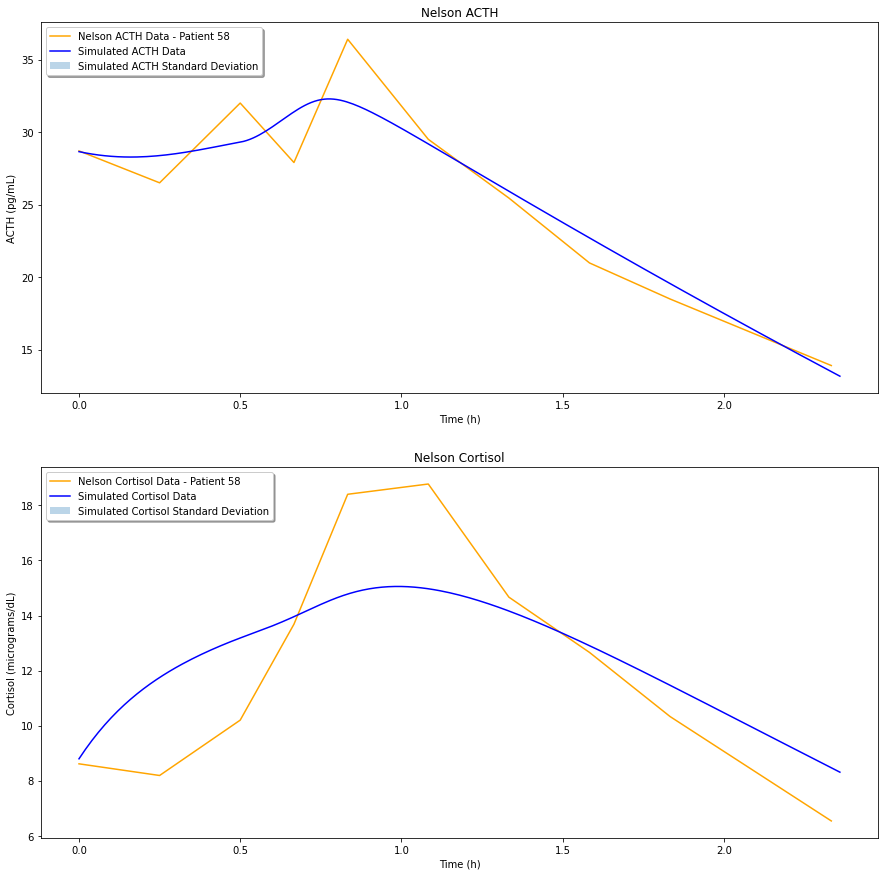

In [256]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (15, 15))

ax1.plot(nelsonACTH[:,0], nelsonACTH[:,59], label = "Nelson ACTH Data - Patient 58", color = "orange")
ax1.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Simulated ACTH Data", color = "blue")
ax1.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.3, label = "Simulated ACTH Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "Nelson ACTH")

ax2.plot(nelsonCortisol[:,0], nelsonCortisol[:,59], label = "Nelson Cortisol Data - Patient 58", color = "orange")
ax2.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Simulated Cortisol Data", color = "blue")
ax2.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.3, label = "Simulated Cortisol Standard Deviation")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Nelson Cortisol")

plt.savefig("nelson-patient24-1-iteration-plus-stress-input.png", dpi = 300)

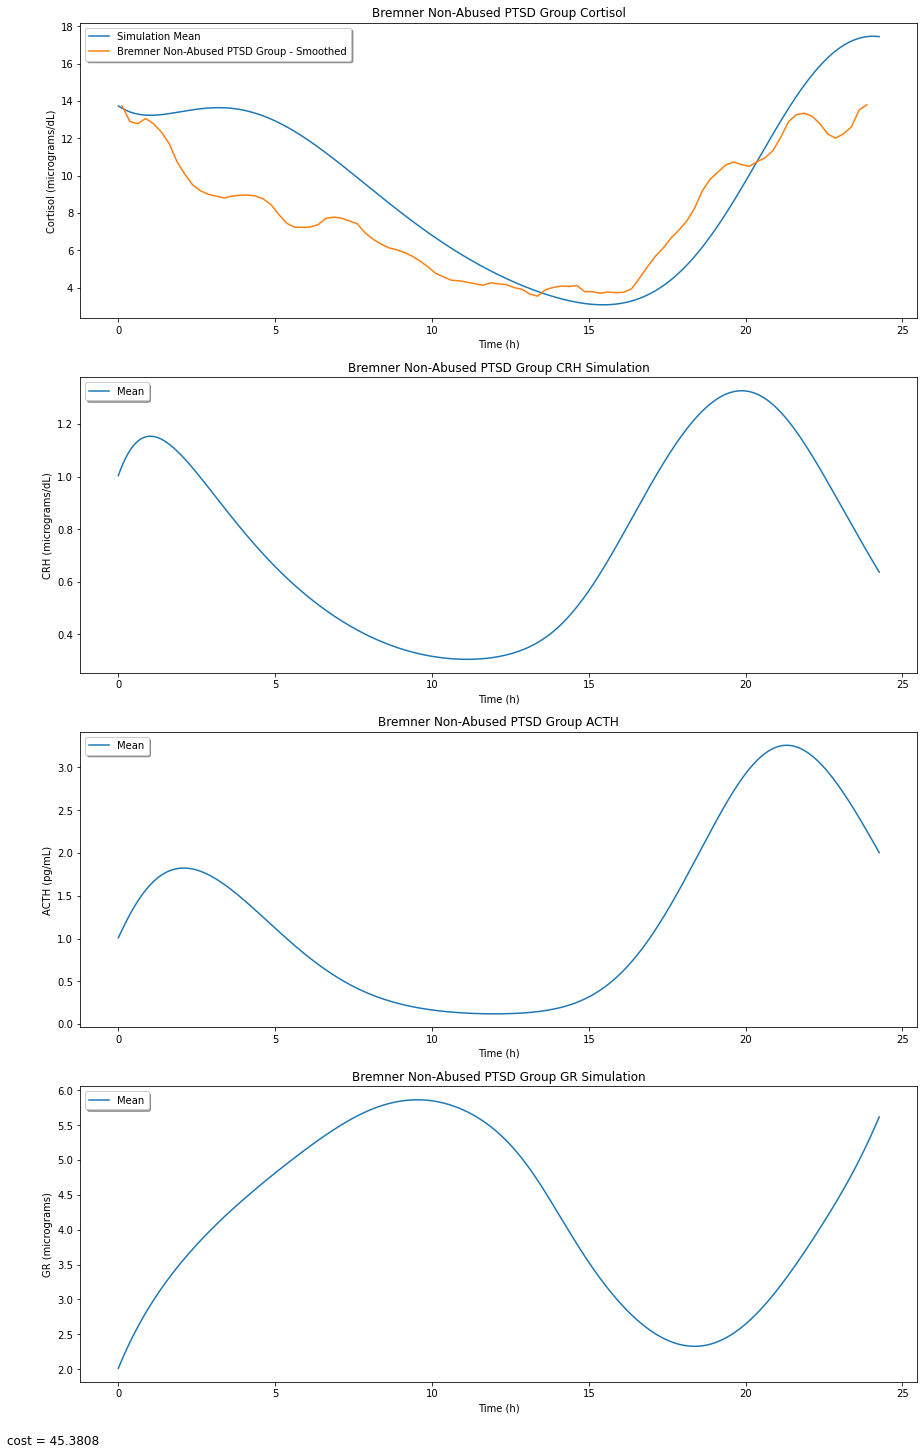

In [139]:
%matplotlib inline
# plot of raw data with simulation data for cortisol, then just simulation data for crh and acth

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(15,25))
ax1.plot(optimizedSimData[:,0], sims_cort, label = "Simulation Mean")
ax1.plot(bremnerAbusedPTSDCortisol_rearr_smooth[:,0], bremnerAbusedPTSDCortisol_rearr_smooth[:,1], label = "Bremner Non-Abused PTSD Group - Smoothed")
# for more than 1 iteration, uncomment below
#ax1.plot(optimizedSimData[:,0], np.mean(sims_cort, axis = 1), label = "Simulation Mean")
#ax1.fill_between(optimizedSimData[:,0], np.mean(sims_cort, axis = 1) - np.std(sims_cort, axis = 1), np.mean(sims_cort, axis = 1) + np.std(sims_cort, axis = 1), alpha = 0.5, label = "Simulation Standard Deviation")
ax1.legend(loc = "upper left", shadow = True, fancybox = True)
ax1.set(xlabel = "Time (h)", ylabel = "Cortisol (micrograms/dL)", title = "Bremner Non-Abused PTSD Group Cortisol")
ax2.plot(optimizedSimData[:,0], sims_crh, label = "Mean")
# for more than 1 iteration, uncomment below
#ax2.plot(optimizedSimData[:,0], np.mean(sims_crh, axis = 1), label = "Mean")
#ax2.fill_between(optimizedSimData[:,0], np.mean(sims_crh, axis = 1) - np.std(sims_crh, axis = 1), np.mean(sims_crh, axis = 1) + np.std(sims_crh, axis = 1), alpha = 0.5, label = "Standard Deviation")
ax2.legend(loc = "upper left", shadow = True, fancybox = True)
ax2.set(xlabel = "Time (h)", ylabel = "CRH (micrograms/dL)", title = "Bremner Non-Abused PTSD Group CRH Simulation")
ax3.plot(optimizedSimData[:,0], sims_acth, label = "Mean")
#ax3.plot(golierNonPTSDNonExposedACTH_rearr[:,0], golierNonPTSDNonExposedACTH_rearr[:,1], label = "Golier Non-PTSD Trauma-Exposed Group")
# for more than 1 iteration, uncomment below
#ax3.plot(optimizedSimData[:,0], np.mean(sims_acth, axis = 1), label = "Mean")
#ax3.fill_between(optimizedSimData[:,0], np.mean(sims_acth, axis = 1) - np.std(sims_acth, axis = 1), np.mean(sims_acth, axis = 1) + np.std(sims_acth, axis = 1), alpha = 0.5, label = "Standard Deviation")
ax3.legend(loc = "upper left", shadow = True, fancybox = True)
ax3.set(xlabel = "Time (h)", ylabel = "ACTH (pg/mL)", title = "Bremner Non-Abused PTSD Group ACTH")
ax4.plot(optimizedSimData[:,0], sims_gr, label = "Mean")
# for more than 1 iteration, uncomment below
#ax4.plot(optimizedSimData[:,0], np.mean(sims_gr, axis = 1), label = "Mean")
#ax4.fill_between(optimizedSimData[:,0], np.mean(sims_gr, axis = 1) - np.std(sims_gr, axis = 1), np.mean(sims_gr, axis = 1) + np.std(sims_gr, axis = 1), alpha = 0.5, label = "Standard Deviation")
ax4.legend(loc = "upper left", shadow = True, fancybox = True)
ax4.set(xlabel = "Time (h)", ylabel = "GR (micrograms)", title = "Bremner Non-Abused PTSD Group GR Simulation")

txt = "cost = 45.3808"
plt.figtext(0.1, 0.09, txt, wrap = True, horizontalalignment = 'center', fontsize = 12)
plt.savefig("sriram-1-iteration-all-params-bremnerNonAbusedPTSD-rearr-smoothed-expanded-bounds.png", dpi = 300)


## No Optimization Run and Plot

In [817]:
yin_params = np.genfromtxt("yin-param-sets-marginal.txt")

In [20]:
cost_vals = np.zeros((len(yin_params), 2))

In [42]:
for i in range(len(yin_params)):
    cost_vals[i,0] = yin_params[i,0]
    cost_vals[i,1] = cost_fun(yin_params[i,1:])

In [722]:
idx = np.arange(len(cost_vals))
idx = np.hstack((idx[:23],idx[24:32],idx[33:53],idx[54:56],idx[57:63],idx[64:90],idx[91:103],idx[104:118],idx[119:129],idx[130:131],idx[132:134],idx[135:153],idx[154:163],idx[164:187],idx[188:196],idx[197:199],idx[200:206],idx[207:212],idx[213:219],idx[220:226],idx[227:230],idx[231:236],idx[237:239],idx[240:250],idx[251:251],idx[252:270],idx[271:289],idx[290:294],idx[295:297],idx[298:304],idx[305:311],idx[312:340],idx[341:354],idx[355:360],idx[361:378],idx[379:390],idx[391:400],idx[401:409],idx[410:415],idx[416:416],idx[417:423],idx[424:430],idx[431:458],idx[459:465],idx[466:467],idx[468:468],idx[469:473],idx[474:479],idx[480:485],idx[486:494],idx[495:499],idx[500:507],idx[508:511],idx[512:514],idx[515:532],idx[533:538],idx[539:550],idx[551:559],idx[560:572],idx[573:578],idx[579:586],idx[587:592],idx[593:604],idx[605:605],idx[606:627],idx[628:645],idx[646:661],idx[662:671],idx[672:679],idx[680:708],idx[709:717],idx[718:732],idx[733:735],idx[736:743],idx[744:751],idx[752:763],idx[764:776],idx[777:780],idx[781:790],idx[791:805],idx[806:808],idx[809:813],idx[814:816],idx[817:827],idx[828:850],idx[851:861],idx[862:866],idx[867:871],idx[872:894],idx[895:899],idx[900:917],idx[918:919],idx[920:920],idx[921:922],idx[923:932],idx[933:937],idx[938:939],idx[940:945],idx[946:959],idx[960:963],idx[964:976],idx[977:987],idx[988:]))


In [723]:
for i in range(len(cost_vals)):
    if cost_vals[i,1] == np.amax(cost_vals[idx,1]):
        next_max = i
        print(i)

733


In [727]:
print(cost_vals[118,:])

[1.19000000e+02 5.49239572e+08]


In [50]:
np.savetxt("yin-params-cost-values-marginal.txt", cost_vals)

In [731]:
print(yin_params[118,1:])

[1.21269490e+01 1.67307203e+00 3.00000000e+00 1.79852230e+00
 1.01371652e+01 1.49246264e+00 3.51810447e-01 1.20000000e+00
 1.05550207e-03 4.12336397e-02 5.12003625e-03 1.00000000e-02
 1.00364474e-01 4.14434982e+00 4.45172034e+00 5.00000000e-02
 2.00000000e+00 2.66569522e-02 5.82948201e-01 8.98223853e-02]


In [ ]:
#kp2 = 4
#kp3 = 7
#kb = 15

In [818]:
testing_params = yin_params[118,1:]
testing_params[15] = 0.008

In [787]:
print(testing_params)
print(yin_params[118,:])

[1.21269490e+01 5.00000000e-01 3.00000000e+00 1.79852230e+00
 1.01371652e+01 1.49246264e+00 3.51810447e-01 1.20000000e+00
 1.05550207e-03 4.12336397e-02 5.12003625e-03 1.00000000e-02
 1.00364474e-01 4.14434982e+00 4.45172034e+00 5.00000000e-02
 2.00000000e+00 2.66569522e-02 5.82948201e-01 8.98223853e-02]
[1.19000000e+02 1.21269490e+01 5.00000000e-01 3.00000000e+00
 1.79852230e+00 1.01371652e+01 1.49246264e+00 3.51810447e-01
 1.20000000e+00 1.05550207e-03 4.12336397e-02 5.12003625e-03
 1.00000000e-02 1.00364474e-01 4.14434982e+00 4.45172034e+00
 5.00000000e-02 2.00000000e+00 2.66569522e-02 5.82948201e-01
 8.98223853e-02]


## Load Parameter Sets and Save Hormone Concentration Data

In [58]:
loaded_params = np.genfromtxt("sriram-opt-pars-carrollControl-rearr-1-all-params-expanded-bounds.txt")
y0 = np.genfromtxt("sriram-y0-carrollControl-rearr-1-all-params-expanded-bounds.txt")
bounds = np.genfromtxt("sriram-bounds-carrollControl-rearr-1-all-params-expanded-bounds.txt")

In [59]:
# if loading only a single iteration
loaded_params = loaded_params[1:]

# if loading multiple iterations
#loaded_params = loaded_params[1:,:]

In [60]:
# plug the optimized parameters into the solver
optimizedSimData = model(loaded_params, y0, timeLength)
    
# save CRH, cortisol and ACTH data into sims arrays
sims_gr = optimizedSimData[:,4]
sims_cort = optimizedSimData[:,3]
sims_acth = optimizedSimData[:,2]
sims_crh = optimizedSimData[:,1]

### Stuff for Checking Parameter Sets Generated Externally

In [98]:
cort_data = np.zeros((2403,len(loaded_params)))
for i in range(len(loaded_params)):
    cort_data[:,i] = np.transpose(np.hstack((i+1,model(loaded_params[i,1:], y0, timeLength)[:,3])))

In [100]:
time_data = np.zeros((2403,len(loaded_params)))
for i in range(len(loaded_params)):
    time_data[:,i] = np.transpose(np.hstack((i+1,model(loaded_params[i,1:], y0, timeLength)[:,0])))

In [102]:
np.savetxt("sriram-cort-data-yehudaControl-1000-all-params.txt", cort_data)

In [103]:
np.savetxt("sriram-time-data-yehudaControl-1000-all-params.txt", time_data)

In [725]:
sim = model(yin_params[next_max,1:], y0, timeLength)

In [814]:
sim = model(testing_params, y0, timeLength)

In [819]:
print(cost_fun(testing_params))


921758398.1845118


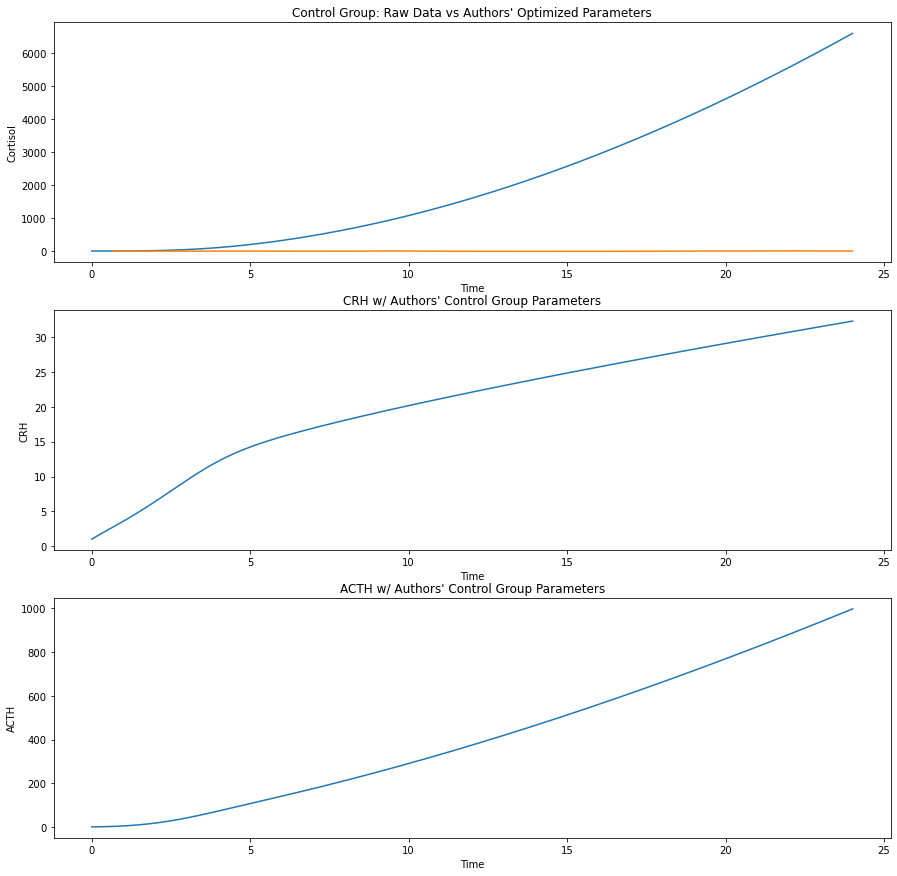

In [816]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, figsize = (15,15))
ax1.plot(sim[:,0], sim[:,3], label = "Simulation")
ax1.plot(yehudaControlCortisol[:,0], yehudaControlCortisol[:,1], label = "Yehuda Control Group")
ax1.set(xlabel = "Time", ylabel = "Cortisol", title = "Control Group: Raw Data vs Authors' Optimized Parameters")
ax2.plot(sim[:,0], sim[:,1])
ax2.set(xlabel = "Time", ylabel = "CRH", title = "CRH w/ Authors' Control Group Parameters")
ax3.plot(sim[:,0], sim[:,2])
ax3.set(xlabel = "Time", ylabel = "ACTH", title = "ACTH w/ Authors' Control Group Parameters")

plt.savefig("testing-params-kb-0.01.pdf", dpi = 300)

## Recreate Figure 4 of Sriram Paper

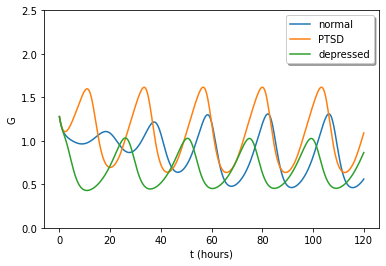

In [61]:
# create Fig 4 of free glucocorticoid receptor level
timeLength = (0,120)
t_end = 120.01

normal = model([10.1, 1.51], y0, timeLength)
PTSD = model([17.5, 1.17], y0, timeLength)
depressed = model([13.7, 1.6], y0, timeLength)

G_normal = G_tot - normal[:,4]
G_PTSD = G_tot - PTSD[:,4]
G_depressed = G_tot - depressed[:,4]

plt.plot(normal[:,0], G_normal, label='normal')
plt.plot(PTSD[:,0], G_PTSD, label='PTSD')
plt.plot(depressed[:,0], G_depressed, label='depressed')
plt.ylim(0,2.5)
plt.xlabel('t (hours)')
plt.ylabel('G')
plt.legend(loc = "upper right", shadow = True, fancybox = True)

## PyCont Bifurcation Analysis

In [8]:
# Setting up PyDSTool solver
DSargs_normal = args()
DSargs_normal.name = 'Normal Cortisol'
DSargs_normal.ics = icdict
DSargs_normal.pars = pardict_normal
DSargs_normal.tdata = [0,120]
DSargs_normal.varspecs = vardict

# setting up for PTSD initial conditions
DSargs_PTSD = args()
DSargs_PTSD.name = 'PTSD Cortisol'
DSargs_PTSD.ics = icdict
DSargs_PTSD.pars = pardict_PTSD
DSargs_PTSD.tdata = [0,120]
DSargs_PTSD.varspecs = vardict

# setting up for depressed initial conditions
DSargs_depressed = args()
DSargs_depressed.name = 'Depressed Cortisol'
DSargs_depressed.ics = icdict
DSargs_depressed.pars = pardict_depressed
DSargs_depressed.tdata = [0,120]
DSargs_depressed.varspecs = vardict

In [7]:
# RHS of ODEs for PyDSTool
vardict = {'CRH':'k_stress*(k_i^n2/(k_i^n2 + GR^n2)) - V_S3*(CRH/(K_m1 + CRH)) - K_d1*CRH', 'ACTH':'K_P2*CRH*(k_i^n2/(k_i^n2 + GR^n2)) - V_S4*(ACTH/(K_m2 + ACTH)) - K_d2*ACTH', 'CORT':'K_P3*ACTH - V_S5*(CORT/(K_m3 + CORT)) - K_d3*CORT', 'GR':'K_b*CORT*(G_tot - GR) + V_S2*(GR^n1/(K1^n1 + GR^n1)) - K_d5*GR'}

In [10]:
# Solve with PyDSTool

DS_normal = Vode_ODEsystem(DSargs_normal)
DS_PTSD = Vode_ODEsystem(DSargs_PTSD)
DS_depressed = Vode_ODEsystem(DSargs_depressed)

In [11]:
# solve the system for normal ICs
traj_normal = DS_normal.compute('normal cortisol production')
pts_normal = traj_normal.sample()

In [12]:
# solve the system for PTSD ICs
traj_PTSD = DS_PTSD.compute('PTSD cortisol production')
pts_PTSD = traj_PTSD.sample()

In [176]:
# solve the system for depressed ICs
traj_depressed = DS_depressed.compute('Depressed cortisol production')
pts_depressed = traj_depressed.sample()

In [178]:
P = ContClass(DS)

In [179]:
PCargs_normal = args(name='normal bifurcation test', type='EP-C')
PCargs_normal.freepars = ['k_stress']
PCargs_normal.StepSize = 1e-2
PCargs_normal.MaxNumPoints = 350
PCargs_normal.MaxStepSize = 1.
PCargs_normal.LocBifPoints = 'all'
PCargs_normal.verbosity = 2
PCargs_normal.SaveEigen = 'True'
P.newCurve(PCargs_normal)

In [180]:
%%time
P['normal bifurcation test'].forward()
#if 0:
#    P.display(('k_stress','CORT'), stability=True)
#    show()

ValueError: math domain error

In [175]:
np.arange(len(cost_vals))!=251

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

## To Change Data Set Being Matched:

1. Change y0 to indicate the first cortisol data point and the first ACTH data point when available. Otherwise, just start with 1 on each and 2 on GR
2. Consider changing the bounds for parameters. They needed to be widened for the Carroll data, for instance
3. In the cost function, change the data sets used for the splines and the points used in the computation of SSE
4. Change the variable cost to either use only cortisol or the average of cortisol and ACTH SSE
5. Change the filenames where the data will be saved after it is computed!
6. Change the graph titles and legend labels
7. MAKE SURE THE DATA SET'S TIMESCALE IS IN HOURS